# EU Climate Policy Evolution Analysis

This notebook analyzes the evolution of EU climate policy design, focusing on two core dimensions:
1. **Sectoral specificity**: How specific are the sectors targeted by policy measures?
2. **Responsibility allocation**: Who are the responsible actors or authorities identified?

Our research question is: **How does climate policy design in the EU change over time with respect to the specificity of sectors and the allocation of responsibility?**

This analysis uses the POLIANNA dataset which provides annotated policy documents for rigorous, text-based analysis.

## 1. Data Exploration and Assessment

We'll start by loading the preprocessed POLIANNA dataset and exploring its structure, particularly focusing on Actor tags.

In [37]:
# Import required libraries
import json
import sys
import pandas as pd
import numpy as np
import collections
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import re
from datetime import datetime

# Add project root to path
sys.path.insert(0, '..')
from src.experiment_utils.helper_classes import token, span, repository
from src.d02_corpus_statistics.corpus import Corpus
from definitions import ROOT_DIR

# Set plotting style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

### 1.1 Loading the Dataset

We'll load the preprocessed POLIANNA dataset from the PKL file.

In [38]:
# Load the preprocessed dataframe
dataframe_dir = os.path.join(ROOT_DIR, 'data/preprocessed_dataframe.pkl')
stat_df = pd.read_pickle(dataframe_dir)

# Create a corpus object (excluding front matter and whereas clauses)
corpus = Corpus(stat_df)

# Display basic information
print(f"Number of documents: {corpus.df.shape[0]}")
print(f"Number of annotators: {len(corpus.annotators)}")
print(f"Finished annotators: {corpus.finished_annotators}")

Number of documents: 412
Number of annotators: 7
Finished annotators: ['C', 'F', 'B', 'A']


In [39]:
# Display the first few rows of the dataframe
corpus.df.head()

,Policy,Text,Tokens,Article_State,Finished_Annotators,Curation,A,C,F,B,E,G,D
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_43,,article 43\r\nexercise of the delegation\r\n1....,"[token id: T1, start:0 stop:7 text:article tag...",CURATION_FINISHED,"[A, C]",[span id:CUR0 annotator:Curation layer:Instrum...,[span id:A1 annotator:A layer:Instrumenttypes ...,[span id:C1 annotator:C layer:Policydesignchar...,,,,,
EU_32019R0631_Title_0_Chapter_0_Section_0_Article_12,,article 12\r\nreal-world co2 emissions and fue...,"[token id: T459, start:0 stop:7 text:article t...",CURATION_FINISHED,"[F, B]",[span id:CUR36 annotator:Curation layer:Instru...,,,[span id:F1 annotator:F layer:Instrumenttypes ...,[span id:B1 annotator:B layer:Policydesignchar...,,,
EU_32018L2001_Title_0_Chapter_0_Section_0_Article_11,,article 11\r\njoint projects between member st...,"[token id: T974, start:0 stop:7 text:article t...",CURATION_FINISHED,"[C, F]",[span id:CUR116 annotator:Curation layer:Instr...,,[span id:C28 annotator:C layer:Instrumenttypes...,[span id:F58 annotator:F layer:Instrumenttypes...,,,,
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_56,,article 56\r\namendments to directive (eu) 201...,"[token id: T2008, start:0 stop:7 text:article ...",CURATION_FINISHED,"[A, C]",[span id:CUR202 annotator:Curation layer:Polic...,[span id:A38 annotator:A layer:Policydesigncha...,[span id:C129 annotator:C layer:Policydesignch...,,,,,
EU_32018L2001_Title_0_Chapter_0_Section_0_Article_03,,article 3\r\nbinding overall union target for ...,"[token id: T2220, start:0 stop:7 text:article ...",CURATION_FINISHED,"[C, F, B]",[span id:CUR211 annotator:Curation layer:Instr...,,[span id:C138 annotator:C layer:Instrumenttype...,[span id:F165 annotator:F layer:Instrumenttype...,[span id:B27 annotator:B layer:Instrumenttypes...,,,


### 1.2 Extracting Document Metadata

Let's extract key metadata from the documents to understand the temporal distribution.

In [40]:
# Extract policy names and create a mapping to their years (from CELEX numbers)
policy_metadata = {}
unique_policies = set()

# Define regex pattern to extract year from CELEX number (format: 32004L0008)
celex_pattern = re.compile(r'3(\d{4})[A-Z]\d+')

for index, row in corpus.df.iterrows():
    parts = index.split('_')
    if len(parts) >= 2:
        policy = parts[0]
        celex_number = parts[1]
        
        # Extract year from CELEX number using regex
        match = celex_pattern.match(celex_number)
        if match:
            year = int(match.group(1))  # Extract the year part
            document_id = policy + '_' + celex_number
            
            policy_metadata[document_id] = {
                'year': year,
                'type': celex_number[5] if len(celex_number) > 5 else None,  # L for Directive, R for Regulation
                'full_id': index
            }
            unique_policies.add(document_id)

# Create a dataframe for policy metadata
policy_df = pd.DataFrame.from_dict(policy_metadata, orient='index').reset_index()
policy_df.rename(columns={'index': 'policy_id'}, inplace=True)

# Display policy metadata
print(f"Number of unique policies: {len(unique_policies)}")
policy_df.head()

Number of unique policies: 18


,policy_id,year,type,full_id
0,EU_32018R1999,2018,R,EU_32018R1999_Title_0_Chapter_5_Section_3_Arti...
1,EU_32019R0631,2019,R,EU_32019R0631_Title_0_Chapter_0_Section_0_Arti...
2,EU_32018L2001,2018,L,EU_32018L2001_Title_0_Chapter_0_Section_0_Arti...
3,EU_32013R0525,2013,R,EU_32013R0525_Title_0_Chapter_6_Section_0_Arti...
4,EU_32006L0066,2006,L,EU_32006L0066_Title_0_Chapter_0_Section_0_Arti...


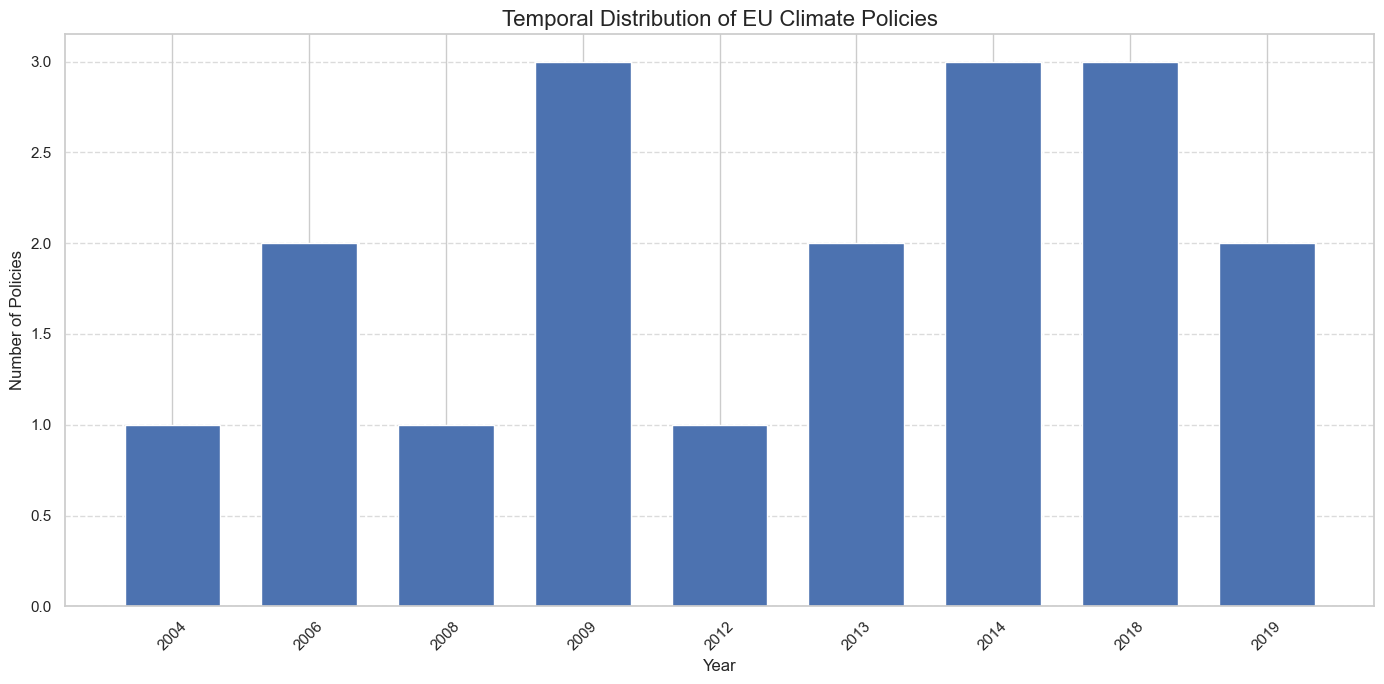

In [50]:
# Prepare data - count policies per year
yearly_counts = policy_df['year'].value_counts().sort_index()

# Visualize the temporal distribution of policies
plt.figure(figsize=(14, 7))

# Create bar plot with exact year placement
bars = plt.bar(yearly_counts.index.astype(str), yearly_counts.values, width=0.7)

# Customize the plot
plt.title('Temporal Distribution of EU Climate Policies', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Policies', fontsize=12)

# Set x-ticks to all years for clarity
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 1.3 Analyzing Actor Tags Distribution

Now we'll focus specifically on Actor tags, especially Authority and Addressee subtypes.

In [42]:
# Create a general repository to match all documents
all_docs = repository()

# Extract all Actor tags
actor_spans = corpus.get_span_list(
    conditional_rep=all_docs, 
    annotators='Curation', 
    item='feature', 
    value='Actor'
)

print(f"Total number of Actor tags: {len(actor_spans)}")

# Categorize by tag type
actor_tag_counts = {}
for span in actor_spans:
    if span.tag not in actor_tag_counts:
        actor_tag_counts[span.tag] = 0
    actor_tag_counts[span.tag] += 1

# Sort by count
actor_tag_counts = dict(sorted(actor_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Display counts
for tag, count in actor_tag_counts.items():
    print(f"{tag}: {count}")

Total number of Actor tags: 5873
Addressee_default: 2079
Addressee_sector: 1355
Authority_default: 897
Authority_monitoring: 659
Addressee_monitored: 483
Authority_legislative: 227
Addressee_resource: 142
Authority_established: 31


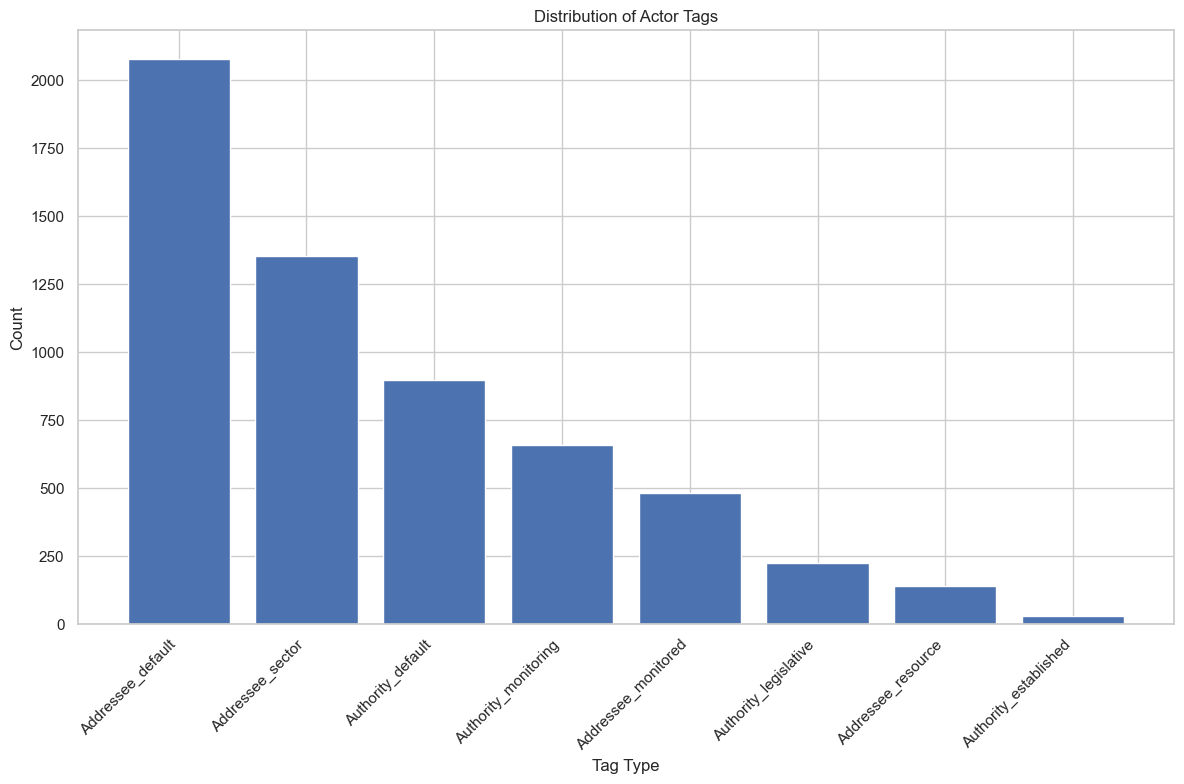

In [43]:
# Visualize Actor tag distribution
plt.figure(figsize=(12, 8))
plt.bar(actor_tag_counts.keys(), actor_tag_counts.values())
plt.title('Distribution of Actor Tags')
plt.xlabel('Tag Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 1.4 Deep Dive into Authority and Addressee Tags

Let's examine Authority and Addressee tags more specifically and determine which ones have sufficient observations for traditional NLP model training.

In [44]:
# Extract Authority tags
authority_tags = [tag for tag, count in actor_tag_counts.items() if tag.startswith('Authority_')]
authority_counts = {tag: actor_tag_counts[tag] for tag in authority_tags}

# Extract Addressee tags
addressee_tags = [tag for tag, count in actor_tag_counts.items() if tag.startswith('Addressee_')]
addressee_counts = {tag: actor_tag_counts[tag] for tag in addressee_tags}

# Create functions to get examples for each tag
def get_tag_examples(tag, n=5):
    tag_spans = corpus.get_span_list(
        conditional_rep=all_docs, 
        annotators='Curation', 
        item='tag', 
        value=tag
    )
    return [span.text for span in tag_spans[:n]]

# Print Authority tag details
print("=== AUTHORITY TAGS ===")
for tag, count in authority_counts.items():
    examples = get_tag_examples(tag)
    print(f"{tag}: {count} occurrences")
    print(f"Examples: {examples[:3]}...\n")

# Print Addressee tag details
print("\n=== ADDRESSEE TAGS ===")
for tag, count in addressee_counts.items():
    examples = get_tag_examples(tag)
    print(f"{tag}: {count} occurrences")
    print(f"Examples: {examples[:3]}...\n")

=== AUTHORITY TAGS ===
Authority_default: 897 occurrences
Examples: ['european parliament', 'council', 'european parliament']...

Authority_monitoring: 659 occurrences
Examples: ['commission', 'commission', 'commission']...

Authority_legislative: 227 occurrences
Examples: ['commission', 'commission', 'european parliament']...

Authority_established: 31 occurrences
Examples: ['technical committee — motor vehicles', 'union renewable development platform (‘urdp’)', 'urdp']...


=== ADDRESSEE TAGS ===
Addressee_default: 2079 occurrences
Examples: ['european parliament', 'council', 'national authorities']...

Addressee_sector: 1355 occurrences
Examples: ['manufacturers', 'manufacturer', 'manufacturer']...

Addressee_monitored: 483 occurrences
Examples: ['manufacturer', 'member\xa0states', 'member\xa0state']...

Addressee_resource: 142 occurrences
Examples: ['member\xa0states', 'public', 'consumers, builders, architects, engineers, environmental and energy auditors, and installers of buildi

In [45]:
# Define a threshold for "sufficient observations" for NLP training
min_observations = 50

# Identify tags with sufficient/insufficient observations
sufficient_tags = [tag for tag, count in actor_tag_counts.items() if count >= min_observations]
insufficient_tags = [tag for tag, count in actor_tag_counts.items() if count < min_observations]

print(f"Tags with sufficient observations (>={min_observations}):")
for tag in sufficient_tags:
    print(f"- {tag}: {actor_tag_counts[tag]} occurrences")

print(f"\nTags with insufficient observations (<{min_observations}):")
for tag in insufficient_tags:
    print(f"- {tag}: {actor_tag_counts[tag]} occurrences")

Tags with sufficient observations (>=50):
- Addressee_default: 2079 occurrences
- Addressee_sector: 1355 occurrences
- Authority_default: 897 occurrences
- Authority_monitoring: 659 occurrences
- Addressee_monitored: 483 occurrences
- Authority_legislative: 227 occurrences
- Addressee_resource: 142 occurrences

Tags with insufficient observations (<50):
- Authority_established: 31 occurrences


### 1.5 Analyzing Sectoral Tags

Let's also analyze the tags related to sectors, which would be found in the "Technology and application specificity" tagset.

In [46]:
# Extract sector-related tags (Technologyandapplicationspecificity)
sector_spans = corpus.get_span_list(
    conditional_rep=all_docs, 
    annotators='Curation', 
    item='feature', 
    value='Technologyandapplicationspecificity'
)

print(f"Total number of sector-related tags: {len(sector_spans)}")

# Categorize by tag type
sector_tag_counts = {}
for span in sector_spans:
    if span.tag not in sector_tag_counts:
        sector_tag_counts[span.tag] = 0
    sector_tag_counts[span.tag] += 1

# Sort by count
sector_tag_counts = dict(sorted(sector_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Display counts
for tag, count in sector_tag_counts.items():
    print(f"{tag}: {count}")

# Get examples for common sector tags
top_sector_tags = list(sector_tag_counts.keys())[:3]
for tag in top_sector_tags:
    examples = get_tag_examples(tag)
    print(f"\nExamples for {tag}:")
    for ex in examples[:5]:
        print(f"- {ex}")

Total number of sector-related tags: 0


In [47]:
# Identify sector tags with sufficient/insufficient observations
sufficient_sector_tags = [tag for tag, count in sector_tag_counts.items() if count >= min_observations]
insufficient_sector_tags = [tag for tag, count in sector_tag_counts.items() if count < min_observations]

print(f"Sector tags with sufficient observations (>={min_observations}):")
for tag in sufficient_sector_tags:
    print(f"- {tag}: {sector_tag_counts[tag]} occurrences")

print(f"\nSector tags with insufficient observations (<{min_observations}):")
for tag in insufficient_sector_tags:
    print(f"- {tag}: {sector_tag_counts[tag]} occurrences")

Sector tags with sufficient observations (>=50):

Sector tags with insufficient observations (<50):


## 2. Temporal Analysis of Actor and Sector Tags

Now we'll analyze how Actor and Sector tags evolve over time in EU climate policy.

In [48]:
# Create a function to extract year from repository name
def get_year_from_repo(repo_name):
    # Use regex to extract year from CELEX number pattern
    celex_match = re.search(r'3(\d{4})[A-Z]\d+', repo_name)
    if celex_match:
        return int(celex_match.group(1))
    return None

# Create a temporal mapping of Actor tags
actor_temporal_data = []
for span in actor_spans:
    year = get_year_from_repo(span.rep.index_name)
    if year:
        actor_temporal_data.append({
            'year': year,
            'tag': span.tag,
            'text': span.text,
            'document': span.rep.index_name
        })

# Create a temporal mapping of Sector tags
sector_temporal_data = []
for span in sector_spans:
    year = get_year_from_repo(span.rep.index_name)
    if year:
        sector_temporal_data.append({
            'year': year,
            'tag': span.tag,
            'text': span.text,
            'document': span.rep.index_name
        })

# Convert to DataFrames
actor_df = pd.DataFrame(actor_temporal_data)
sector_df = pd.DataFrame(sector_temporal_data)

In [49]:
# Display basic statistics
print(f"Actor temporal data: {len(actor_temporal_data)} annotations across {actor_df['year'].nunique()} years")
print(f"Sector temporal data: {len(sector_temporal_data)} annotations across {sector_df['year'].nunique()} years")

# Show sample of the actor dataframe
actor_df.head()

Actor temporal data: 5873 annotations across 9 years


KeyError: 'year'

### 2.1 Temporal Evolution of Authority vs. Addressee Distribution

In [ ]:
# Classify tags into broad categories
actor_df['category'] = actor_df['tag'].apply(
    lambda x: 'Authority' if x.startswith('Authority_') else 
             ('Addressee' if x.startswith('Addressee_') else 'Other')
)

# Count occurrences by year and category
actor_yearly = actor_df.groupby(['year', 'category']).size().reset_index(name='count')

# Pivot for plotting
actor_yearly_pivot = actor_yearly.pivot(index='year', columns='category', values='count').fillna(0)

# Normalize to percentage
actor_yearly_pivot_pct = actor_yearly_pivot.div(actor_yearly_pivot.sum(axis=1), axis=0) * 100

# Plot both absolute counts and percentages
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Absolute counts
actor_yearly_pivot.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Absolute Counts of Authority vs. Addressee Tags Over Time')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count')
ax1.legend(title='Actor Category')

# Percentage
actor_yearly_pivot_pct.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Relative Proportion of Authority vs. Addressee Tags Over Time')
ax2.set_xlabel('Year')
ax2.set_ylabel('Percentage (%)')
ax2.legend(title='Actor Category')

plt.tight_layout()
plt.show()

### 2.2 Temporal Evolution of Specific Actor Types

In [ ]:
# Get top N most common actor tags
top_n = 5
top_actor_tags = actor_df['tag'].value_counts().head(top_n).index.tolist()

# Filter for only the top tags
top_actor_df = actor_df[actor_df['tag'].isin(top_actor_tags)]

# Count occurrences by year and tag
actor_tag_yearly = top_actor_df.groupby(['year', 'tag']).size().reset_index(name='count')

# Create a line plot showing the evolution of top actor tags over time
plt.figure(figsize=(14, 8))

# Pivot the data for plotting
actor_tag_pivot = actor_tag_yearly.pivot(index='year', columns='tag', values='count').fillna(0)

# Plot
ax = actor_tag_pivot.plot(marker='o', linestyle='-')
plt.title(f'Evolution of Top {top_n} Actor Types Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Actor Type')
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.3 Temporal Evolution of Sector Specificity

In [ ]:
# Categorize sectors by specificity (this would need domain expertise, approximating for now)
specificity_categories = {
    'General': ['Technologyneutral'],
    'Semi-Specific': ['Technology_family', 'Sector_family'],
    'Specific': ['Technology_specific', 'Sector_specific']
}

# Reverse mapping from tag to specificity category
tag_to_specificity = {}
for category, tags in specificity_categories.items():
    for tag in tags:
        tag_to_specificity[tag] = category

# Add specificity category to sector dataframe
sector_df['specificity'] = sector_df['tag'].apply(
    lambda x: tag_to_specificity.get(x, 'Other')
)

# Count occurrences by year and specificity
sector_yearly = sector_df.groupby(['year', 'specificity']).size().reset_index(name='count')

# Pivot for plotting
sector_yearly_pivot = sector_yearly.pivot(index='year', columns='specificity', values='count').fillna(0)

# Calculate percentage
sector_yearly_pivot_pct = sector_yearly_pivot.div(sector_yearly_pivot.sum(axis=1), axis=0) * 100

# Plot both absolute counts and percentages
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Absolute counts
sector_yearly_pivot.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Absolute Counts of Sector Specificity Over Time')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count')
ax1.legend(title='Specificity Level')

# Percentage
sector_yearly_pivot_pct.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Relative Proportion of Sector Specificity Over Time')
ax2.set_xlabel('Year')
ax2.set_ylabel('Percentage (%)')
ax2.legend(title='Specificity Level')

plt.tight_layout()
plt.show()

## 3. Data Assessment for NLP Model Training

Based on our analysis, let's determine which tags have sufficient data for traditional NLP approaches and which would require LLM-based approaches.

In [ ]:
# Define function to assess tag suitability for NLP training
def assess_tag_suitability(tag_counts, min_observations=50):
    results = {
        'suitable_for_traditional_nlp': [],
        'requires_llm_approach': []
    }
    
    for tag, count in tag_counts.items():
        if count >= min_observations:
            results['suitable_for_traditional_nlp'].append((tag, count))
        else:
            results['requires_llm_approach'].append((tag, count))
    
    return results

# Assess Actor tags
actor_assessment = assess_tag_suitability(actor_tag_counts)

# Assess Sector tags
sector_assessment = assess_tag_suitability(sector_tag_counts)

# Print results
print("=== ACTOR TAGS ASSESSMENT ===\n")
print("Suitable for Traditional NLP:")
for tag, count in actor_assessment['suitable_for_traditional_nlp']:
    print(f"- {tag}: {count} occurrences")

print("\nRequires LLM-based Approach:")
for tag, count in actor_assessment['requires_llm_approach']:
    print(f"- {tag}: {count} occurrences")

print("\n=== SECTOR TAGS ASSESSMENT ===\n")
print("Suitable for Traditional NLP:")
for tag, count in sector_assessment['suitable_for_traditional_nlp']:
    print(f"- {tag}: {count} occurrences")

print("\nRequires LLM-based Approach:")
for tag, count in sector_assessment['requires_llm_approach']:
    print(f"- {tag}: {count} occurrences")

## 4. Next Steps: Dual-track Analysis Pipeline Development

Based on our data assessment, we need to develop two complementary approaches:

### 4.1 Traditional NLP Pipeline
For tags with sufficient observations, we'll implement traditional NLP models:
- Named Entity Recognition (NER) for identifying actors and sectors
- Classification for categorizing actor types (authority vs. addressee) and sector specificity

### 4.2 LLM-based Extraction Pipeline
For tags with insufficient observations, we'll use large language models (LLMs):
- Few-shot prompting for tag types with some examples
- Zero-shot prompting for very rare tag types

In the next notebook, we will implement both pipelines and evaluate their performance on the POLIANNA dataset before applying them to additional EU climate policy documents.